# `prachathai-67k` Dataset

This notebook performs a preliminary exploration of the `prachathai-67k` dataset which was scraped from the news site [Prachathai](https://prachatai.com/). We filtered out those articles with less than 500 characters of body text, mostly images and cartoons. It contains 67,889 articles wtih 51,797 tags from August 24, 2004 to November 15, 2018. The dataset was originally scraped by [@lukkiddd](https://github.com/lukkiddd) and cleaned by [@cstorm125](https://github.com/cstorm125).

This dataset is a part of [pyThaiNLP](https://github.com/PyThaiNLP/) Thai text [classification-benchmarks](https://github.com/PyThaiNLP/classification-benchmarks). For the benchmark, we selected the following tags with substantial volume that resemble **classifying types of articles**$^+$:

* `การเมือง` - politics
* `สิทธิมนุษยชน` - human rights
* `คุณภาพชีวิต` - quality of life
* `ต่างประเทศ` - international
* `สังคม` - social
* `สิ่งแวดล้อม` - environment
* `เศรษฐกิจ` - economics
* `วัฒนธรรม` - culture
* `แรงงาน` - labor
* `ความมั่นคง` - national security
* `ไอซีที` - ICT
* `การศึกษา` - education

This is a **multi-label classification task** and we use **F1-score** for each label as the benchmark. The benchmark include both **title classification** and **body classification**.

$^+$ Note that Prachathai.com is a left-leaning, human-right-focused news site, and thus unusual news labels such as human rights and quality of life.

In [1]:
%%capture
%pip install pythainlp emoji

In [2]:
# Download dataset by uncommenting the lines below

# !wget -O prachathai-67k.zip https://www.dropbox.com/s/fsxepdka4l2pr45/prachathai-67k.zip?dl=1
# !unzip -y prachathai-67k.zip

In [3]:
import polars as pl
import numpy as np
from pythainlp.tokenize import THAI2FIT_TOKENIZER
from ast import literal_eval
from tqdm import tqdm
from collections import Counter

#viz
from plotnine import *
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# !wget -O thsarabunnew-webfont.ttf https://github.com/PyThaiNLP/prachathai-67k/raw/master/thsarabunnew-webfont.ttf

fm.fontManager.addfont("thsarabunnew-webfont.ttf")
plt.rc('font', family='TH Sarabun New')

In [5]:
prachathai = pl.read_csv('prachathai-67k.csv', schema_overrides={
    "date": pl.Datetime(time_zone="Asia/Bangkok"),
}).with_columns(
    # The labels aren't JSON :(
    pl.col("labels").map_elements(literal_eval, return_dtype=pl.List(pl.Utf8))
)
print(prachathai.shape)
prachathai.head()

(67889, 5)


url,date,title,body_text,labels
str,"datetime[μs, Asia/Bangkok]",str,str,list[str]
"""https://prachatai.com/print/42""",2004-08-24 21:31:00 +07,"""นักวิจัยหนุน ""แม้ว"" เปิด ""จ…","""ประชาไท --- 23 ส.ค.2547 นักวิ…","[""ข่าว"", ""สิ่งแวดล้อม""]"
"""https://prachatai.com/print/41""",2004-08-24 21:22:00 +07,"""ภาคประชาชนต้านเปิดเสรีจีเอ็มโอ""","""ประชาไท- 23 ส.ค.2547 นักวิชา…","[""ข่าว"", ""สิ่งแวดล้อม""]"
"""https://prachatai.com/print/43""",2004-08-24 22:17:00 +07,"""จุฬาฯ ห่วงจีเอ็มโอลามข้าวไทย""",""" นโยบายที่อนุญาตให้ปลูกร่วมกับ…","[""ข่าว"", ""สิ่งแวดล้อม""]"
"""https://prachatai.com/print/45""",2004-08-24 22:58:00 +07,"""ฟองสบู่การเมืองแตก ทักษิณหมดกึ…","""ประชาไท -- 23 ส.ค. 47 ขาประจำ…","[""ข่าว"", ""การเมือง"", … ""เสวนา""]"
"""https://prachatai.com/print/47""",2004-08-24 23:10:00 +07,"""กอต.เสนอเลิกถนนคลองลาน-อุ้มผาง""","""ประชาไท-23 ส.ค.47 คณะกรรมการอ…","[""ข่าว"", ""สิ่งแวดล้อม""]"


In [6]:
#text processor
import re, emoji,string
def replace_url(text):
    URL_PATTERN = r"""(?i)\b((?:https?:(?:/{1,3}|[a-z0-9%])|[a-z0-9.\-]+[.](?:com|net|org|edu|gov|mil|aero|asia|biz|cat|coop|info|int|jobs|mobi|museum|name|post|pro|tel|travel|xxx|ac|ad|ae|af|ag|ai|al|am|an|ao|aq|ar|as|at|au|aw|ax|az|ba|bb|bd|be|bf|bg|bh|bi|bj|bm|bn|bo|br|bs|bt|bv|bw|by|bz|ca|cc|cd|cf|cg|ch|ci|ck|cl|cm|cn|co|cr|cs|cu|cv|cx|cy|cz|dd|de|dj|dk|dm|do|dz|ec|ee|eg|eh|er|es|et|eu|fi|fj|fk|fm|fo|fr|ga|gb|gd|ge|gf|gg|gh|gi|gl|gm|gn|gp|gq|gr|gs|gt|gu|gw|gy|hk|hm|hn|hr|ht|hu|id|ie|il|im|in|io|iq|ir|is|it|je|jm|jo|jp|ke|kg|kh|ki|km|kn|kp|kr|kw|ky|kz|la|lb|lc|li|lk|lr|ls|lt|lu|lv|ly|ma|mc|md|me|mg|mh|mk|ml|mm|mn|mo|mp|mq|mr|ms|mt|mu|mv|mw|mx|my|mz|na|nc|ne|nf|ng|ni|nl|no|np|nr|nu|nz|om|pa|pe|pf|pg|ph|pk|pl|pm|pn|pr|ps|pt|pw|py|qa|re|ro|rs|ru|rw|sa|sb|sc|sd|se|sg|sh|si|sj|Ja|sk|sl|sm|sn|so|sr|ss|st|su|sv|sx|sy|sz|tc|td|tf|tg|th|tj|tk|tl|tm|tn|to|tp|tr|tt|tv|tw|tz|ua|ug|uk|us|uy|uz|va|vc|ve|vg|vi|vn|vu|wf|ws|ye|yt|yu|za|zm|zw)/)(?:[^\s()<>{}\[\]]+|\([^\s()]*?\([^\s()]+\)[^\s()]*?\)|\([^\s]+?\))+(?:\([^\s()]*?\([^\s()]+\)[^\s()]*?\)|\([^\s]+?\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’])|(?:(?<!@)[a-z0-9]+(?:[.\-][a-z0-9]+)*[.](?:com|net|org|edu|gov|mil|aero|asia|biz|cat|coop|info|int|jobs|mobi|museum|name|post|pro|tel|travel|xxx|ac|ad|ae|af|ag|ai|al|am|an|ao|aq|ar|as|at|au|aw|ax|az|ba|bb|bd|be|bf|bg|bh|bi|bj|bm|bn|bo|br|bs|bt|bv|bw|by|bz|ca|cc|cd|cf|cg|ch|ci|ck|cl|cm|cn|co|cr|cs|cu|cv|cx|cy|cz|dd|de|dj|dk|dm|do|dz|ec|ee|eg|eh|er|es|et|eu|fi|fj|fk|fm|fo|fr|ga|gb|gd|ge|gf|gg|gh|gi|gl|gm|gn|gp|gq|gr|gs|gt|gu|gw|gy|hk|hm|hn|hr|ht|hu|id|ie|il|im|in|io|iq|ir|is|it|je|jm|jo|jp|ke|kg|kh|ki|km|kn|kp|kr|kw|ky|kz|la|lb|lc|li|lk|lr|ls|lt|lu|lv|ly|ma|mc|md|me|mg|mh|mk|ml|mm|mn|mo|mp|mq|mr|ms|mt|mu|mv|mw|mx|my|mz|na|nc|ne|nf|ng|ni|nl|no|np|nr|nu|nz|om|pa|pe|pf|pg|ph|pk|pl|pm|pn|pr|ps|pt|pw|py|qa|re|ro|rs|ru|rw|sa|sb|sc|sd|se|sg|sh|si|sj|Ja|sk|sl|sm|sn|so|sr|ss|st|su|sv|sx|sy|sz|tc|td|tf|tg|th|tj|tk|tl|tm|tn|to|tp|tr|tt|tv|tw|tz|ua|ug|uk|us|uy|uz|va|vc|ve|vg|vi|vn|vu|wf|ws|ye|yt|yu|za|zm|zw)\b/?(?!@)))"""
    return re.sub(URL_PATTERN, 'xxurl', text)

def replace_rep(text):
    def _replace_rep(m):
        c,cc = m.groups()
        return f'{c}xxrep'
    re_rep = re.compile(r'(\S)(\1{2,})')
    return re_rep.sub(_replace_rep, text)

def ungroup_emoji(toks):
    res = []
    for tok in toks:
        if emoji.emoji_count(tok) == len(tok):
            for char in tok:
                res.append(char)
        else:
            res.append(tok)
    return res

def process_text(text):
    #pre rules
    res = text.lower().strip()
    res = replace_url(res)
    res = replace_rep(res)
    res = ''.join([char for char in res if char not in string.punctuation])
    
    #tokenize
    res = [word for word in THAI2FIT_TOKENIZER.word_tokenize(res) if word and not re.search(pattern=r"\s+", string=word)]

    #post rules
    res = ungroup_emoji(res)

    return res

## Labels

### Tag Distribution

In [7]:
label_df = prachathai.filter(
    pl.col('labels').list.len() > 0
)['labels'].list.explode().rename('label').value_counts(name='cnt').sort('cnt', descending=True)
print(label_df.shape)
with pl.Config(tbl_rows=15):
    display(label_df.head(15))

(51797, 2)


label,cnt
str,u32
"""ข่าว""",53448
"""การเมือง""",39124
"""สิทธิมนุษยชน""",15067
"""คุณภาพชีวิต""",11316
"""บทความ""",9571
"""ต่างประเทศ""",8114
"""สังคม""",7893
"""สิ่งแวดล้อม""",7703
"""เศรษฐกิจ""",5008


In [8]:
label_df.tail(10)

label,cnt
str,u32
"""ประสุตร รัศมีแพทย์""",1
"""ให้เหล้าเท่ากับแช่ง""",1
"""การผลักดันกลับคนต่างด้าว""",1
"""โก๊ะตี๋ อารามบอย""",1
"""พนักงานริโก้ แมนูแฟคเจอริ่ง""",1
"""การซื้อโฆษณา""",1
"""การทบทวนสถานการณ์สิทธิมนุษยชนไ…",1
"""จรรยาบรรณสื่อมวลชน""",1
"""ประวัติสุรินทร์ พิศสุวรรณ""",1


### Benchmark Labels

Out of over 50,000 tags, we selected 12 tags as our **benchmark labels**.

In [9]:
benchmark_labels = ['การเมือง','สิทธิมนุษยชน','คุณภาพชีวิต','ต่างประเทศ','สังคม',
                  'สิ่งแวดล้อม','เศรษฐกิจ','วัฒนธรรม','แรงงาน','ความมั่นคง',
                  'ไอซีที','การศึกษา']

In [10]:
prachathai_encoded = prachathai.with_columns([
    pl.col('labels').list.contains(label).cast(pl.Int8).alias(label)
    for label in benchmark_labels
])

### Number of Labels Per Sample

In [11]:
corr_df = prachathai_encoded.select(benchmark_labels)

label_cnt = corr_df.select(pl.sum_horizontal(pl.all()).alias('nb_label'))
label_cnt_df = label_cnt['nb_label'].value_counts(name='cnt').sort('cnt', descending=True)
label_cnt_df = label_cnt_df.with_columns(
    (pl.col('cnt') / pl.col('cnt').sum()).alias('per')
)

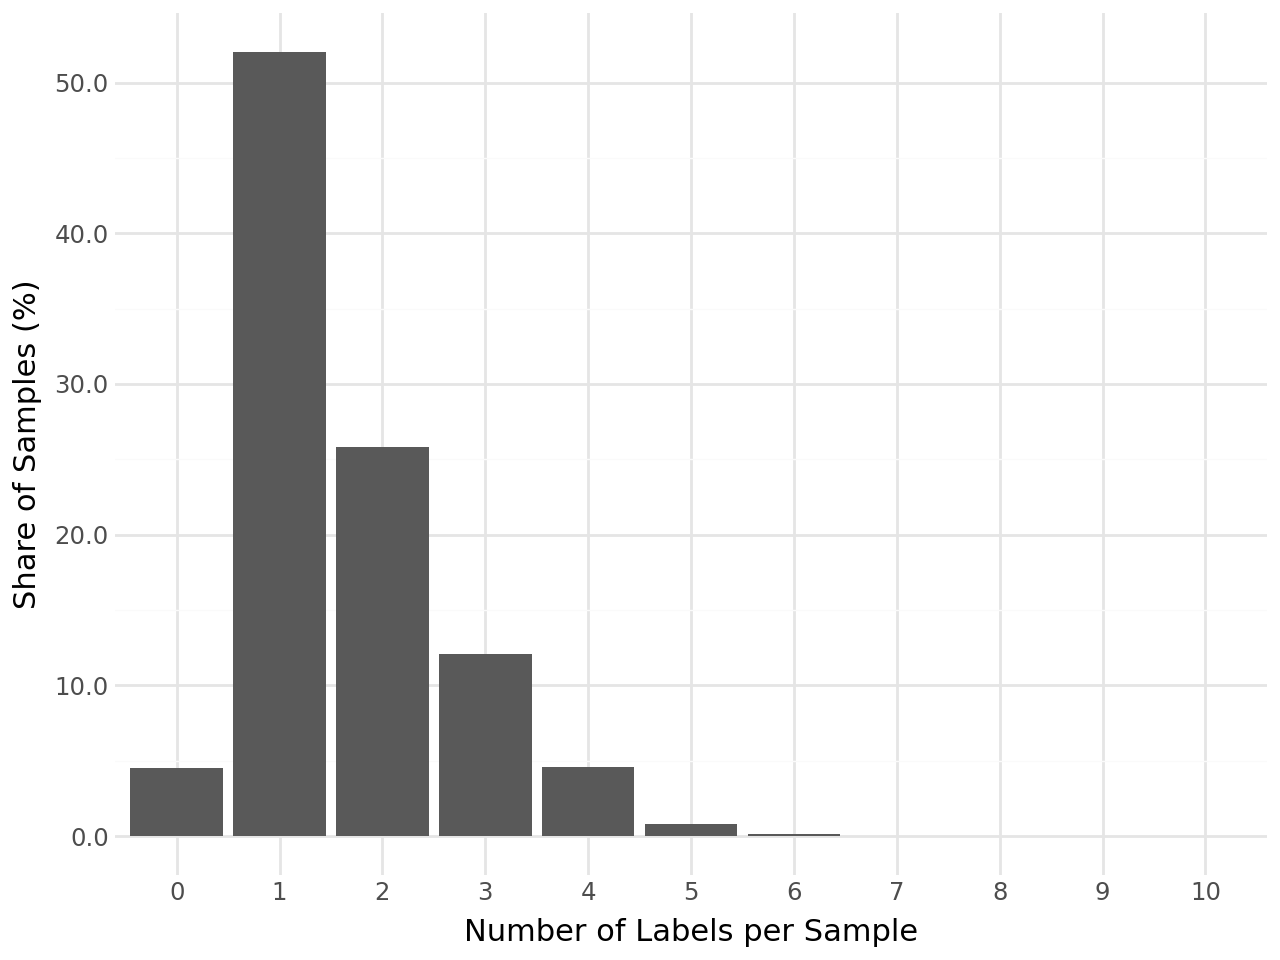

nb_label,cnt,per
i8,u32,f64
1,35320,0.520261
2,17527,0.258171
3,8193,0.120682
4,3124,0.046016
0,3078,0.045339
…,…,…
6,82,0.001208
7,12,0.000177
8,8,0.000118


In [12]:
g = (ggplot(label_cnt_df,aes(x='factor(nb_label)', y='per')) + geom_bar(stat='identity') +
    theme_minimal() + scale_y_continuous(labels = lambda x: np.round(np.array(x)*100,0)) +
    xlab('Number of Labels per Sample') + ylab('Share of Samples (%)'))
display(g)
label_cnt_df

### Benchmark Label Distribution

In [13]:
with pl.Config(tbl_rows=60):
    display(label_df)

label,cnt
str,u32
"""ข่าว""",53448
"""การเมือง""",39124
"""สิทธิมนุษยชน""",15067
"""คุณภาพชีวิต""",11316
"""บทความ""",9571
"""ต่างประเทศ""",8114
"""สังคม""",7893
"""สิ่งแวดล้อม""",7703
"""เศรษฐกิจ""",5008


In [14]:
en_label_map = dict(zip(benchmark_labels, [
    '00 - politics','01 - human_rights','02 - quality_of_life','03 - international',
    '04 -social','05 - environment','06 - economics','07 - culture','08 - labor',
    '09 - national_security','10 - ICT', '11 - education'
]))
label_group_df = (
    corr_df.sum().unpivot(variable_name='label', value_name='cnt')
    .with_columns(
        (pl.col('cnt') / pl.col('cnt').sum()).alias('per'),
        pl.col('label').replace(en_label_map).alias('en_label')
    ).sort('per', descending=True)
)

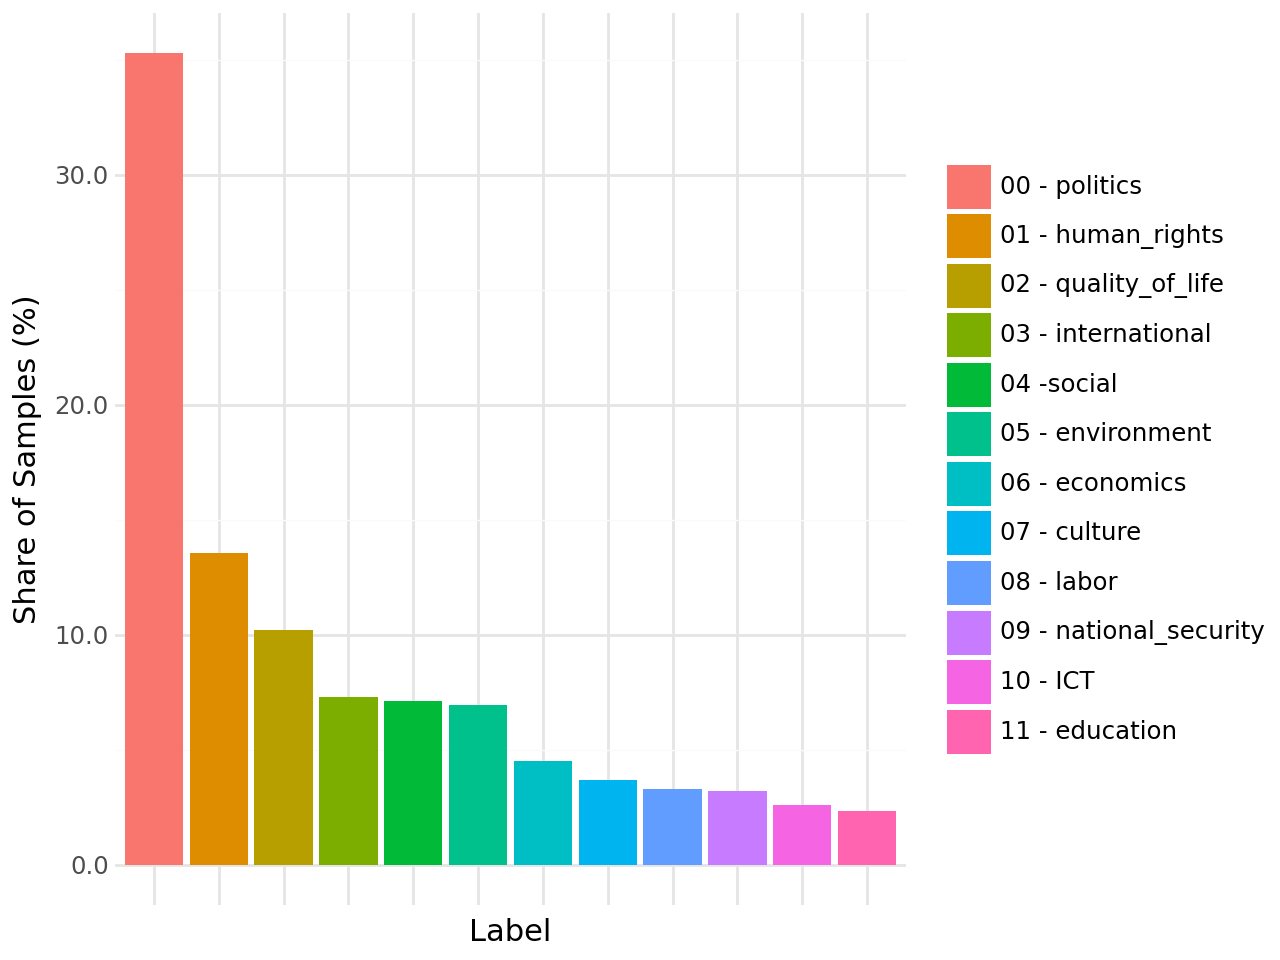

label,cnt,per,en_label
str,i64,f64,str
"""การเมือง""",39095,0.35269,"""00 - politics"""
"""สิทธิมนุษยชน""",15030,0.135591,"""01 - human_rights"""
"""คุณภาพชีวิต""",11308,0.102014,"""02 - quality_of_life"""
"""ต่างประเทศ""",8094,0.073019,"""03 - international"""
"""สังคม""",7892,0.071197,"""04 -social"""
…,…,…,…
"""วัฒนธรรม""",4065,0.036672,"""07 - culture"""
"""แรงงาน""",3630,0.032748,"""08 - labor"""
"""ความมั่นคง""",3542,0.031954,"""09 - national_security"""


In [15]:
g = (ggplot(label_group_df,aes(x='en_label', y='per', fill='en_label')) + geom_bar(stat='identity') +
    theme_minimal() + scale_y_continuous(labels = lambda x: np.round(np.array(x)*100,0)) +
    xlab('Label') + ylab('Share of Samples (%)') +
    theme(axis_text_x = element_blank(),legend_title=element_blank()))
display(g)
label_group_df

### Label Correlation

In [16]:
label_group_df["en_label"]

en_label
str
"""00 - politics"""
"""01 - human_rights"""
"""02 - quality_of_life"""
"""03 - international"""
"""04 -social"""
…
"""07 - culture"""
"""08 - labor"""
"""09 - national_security"""


In [17]:
corr_en_df = corr_df.rename(en_label_map)

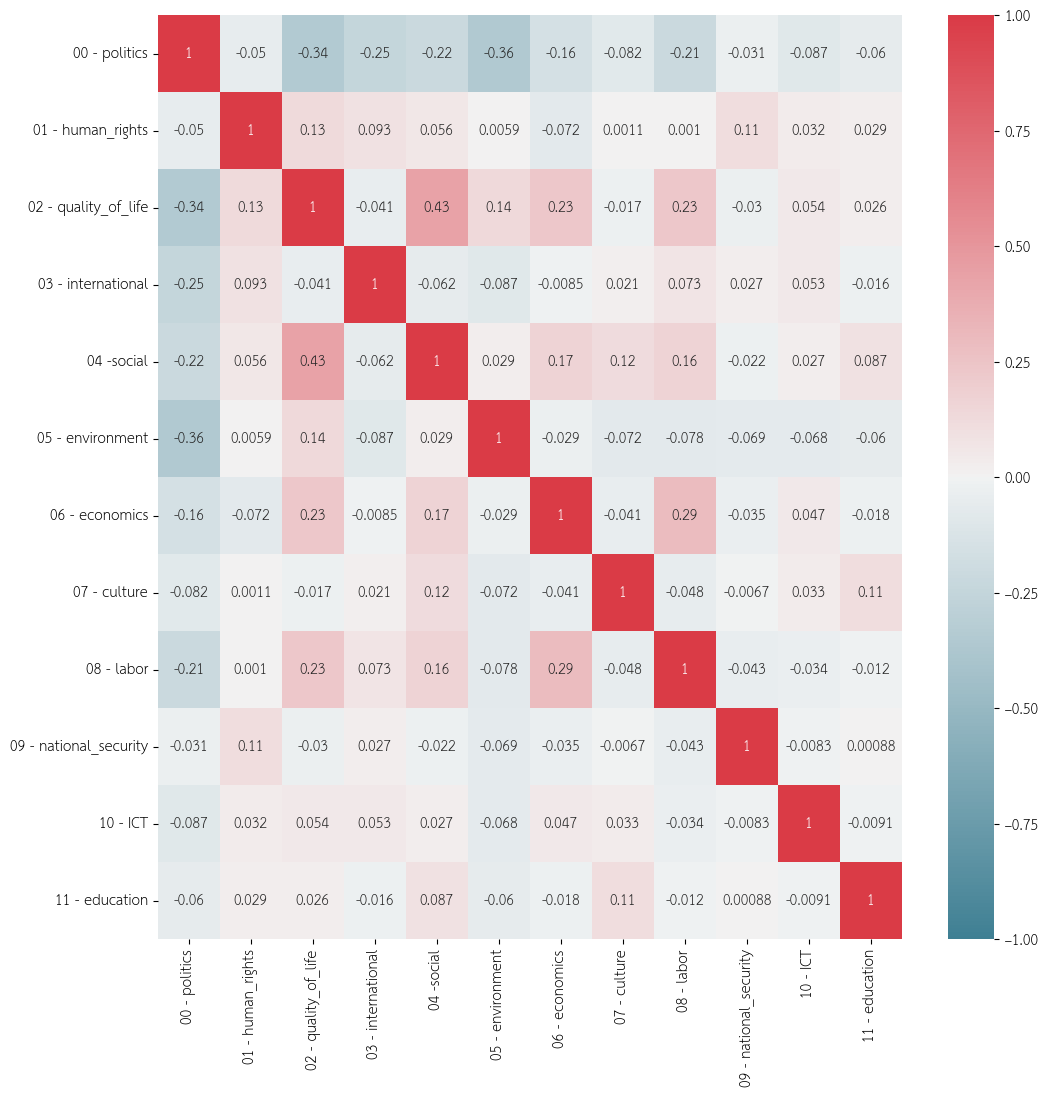

In [18]:
plt.figure(figsize=(12,12))
col_names = corr_en_df.columns
corr = np.corrcoef(corr_df.to_numpy().T)
sns.heatmap(corr, xticklabels=col_names, yticklabels=col_names,
            cmap=sns.diverging_palette(220, 10, as_cmap=True),
            vmin=-1, vmax=1, annot=True)
plt.show()

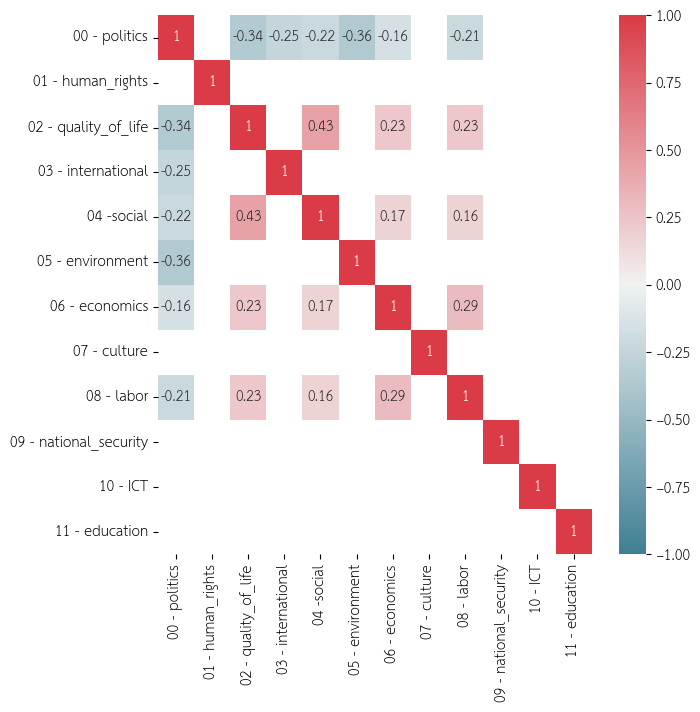

In [19]:
plt.figure(figsize=(7,7))
corr_filtered = np.where((corr > 0.15) | (corr < -0.15), corr, np.nan)
sns.heatmap(corr_filtered, xticklabels=col_names, yticklabels=col_names,
            cmap=sns.diverging_palette(220, 10, as_cmap=True),
            vmin=-1, vmax=1, annot=True)
plt.show()


## Title

In [20]:
from sklearn.feature_extraction.text import CountVectorizer

title_cnt = CountVectorizer(tokenizer=THAI2FIT_TOKENIZER.word_tokenize, token_pattern=None)
title_mat = title_cnt.fit_transform(prachathai['title'].to_numpy())

### Title Word Count Distribution

In [21]:
title_wc = pl.DataFrame({
    'word_count': np.asarray(title_mat.sum(axis=1)).squeeze()
})

Average Title Word Count: 15.362164710041391


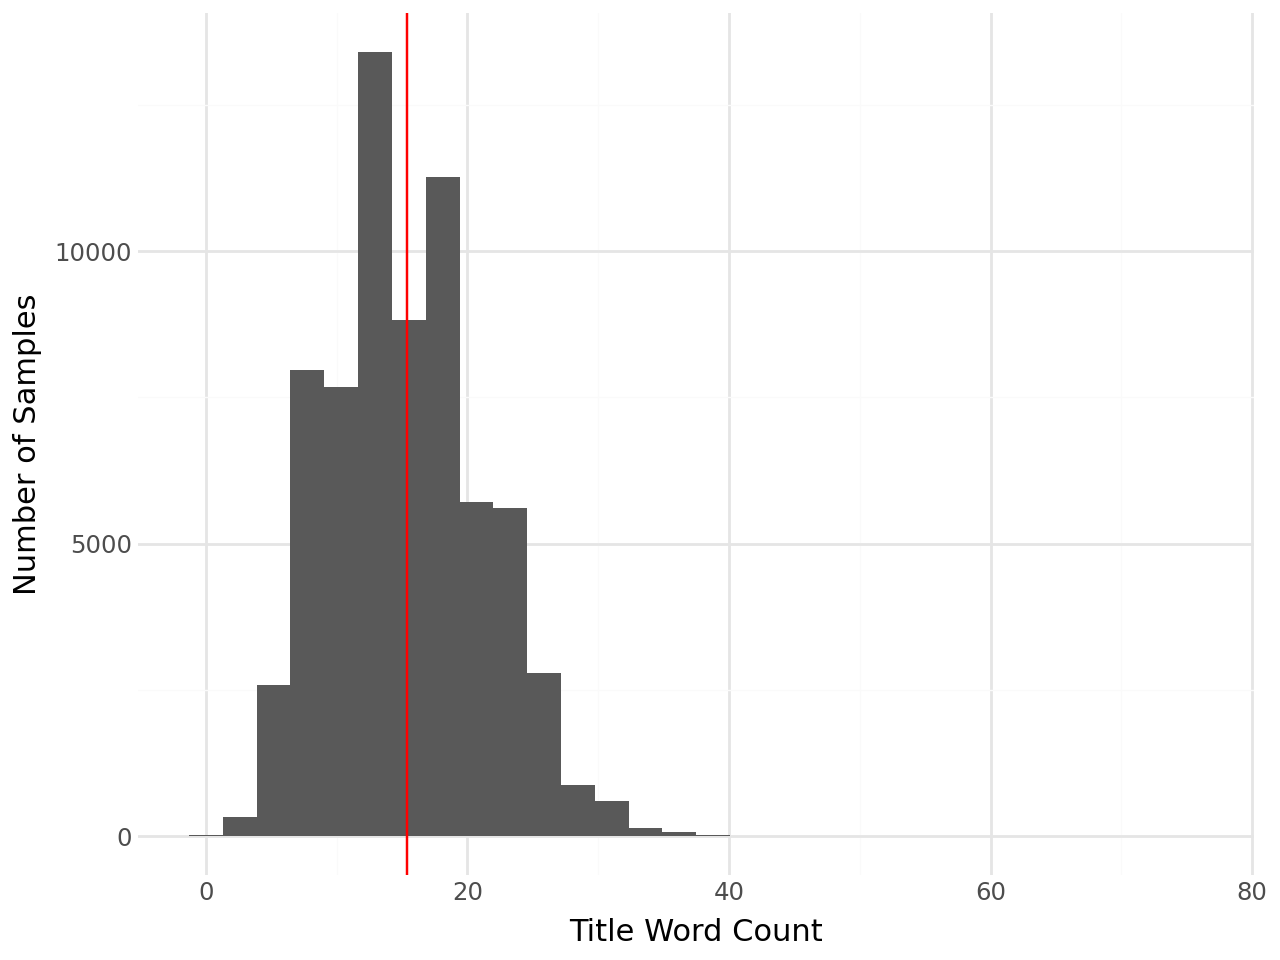

In [22]:
g = (ggplot(title_wc, aes(x='word_count')) + geom_histogram(bins=30) + theme_minimal() +
    xlab('Title Word Count') + ylab('Number of Samples') +
    geom_vline(xintercept = title_wc['word_count'].mean(), color='red'))
print(f'Average Title Word Count: {title_wc['word_count'].mean()}')
g

### Title Word Frequency

In [23]:
title_top = pl.DataFrame({
    'vocab': title_cnt.get_feature_names_out(),
    'cnt': np.asarray(title_mat.sum(axis=0)).squeeze()
}).sort('cnt', descending=True).with_row_index('index')

In [24]:
title_top.head()

index,vocab,cnt
u32,str,i64
0,""" """,190410
1,"""""""",19866
2,"""'""",14812
3,"""-""",12857
4,""":""",11910


Median Title Word Frequency: 1.0


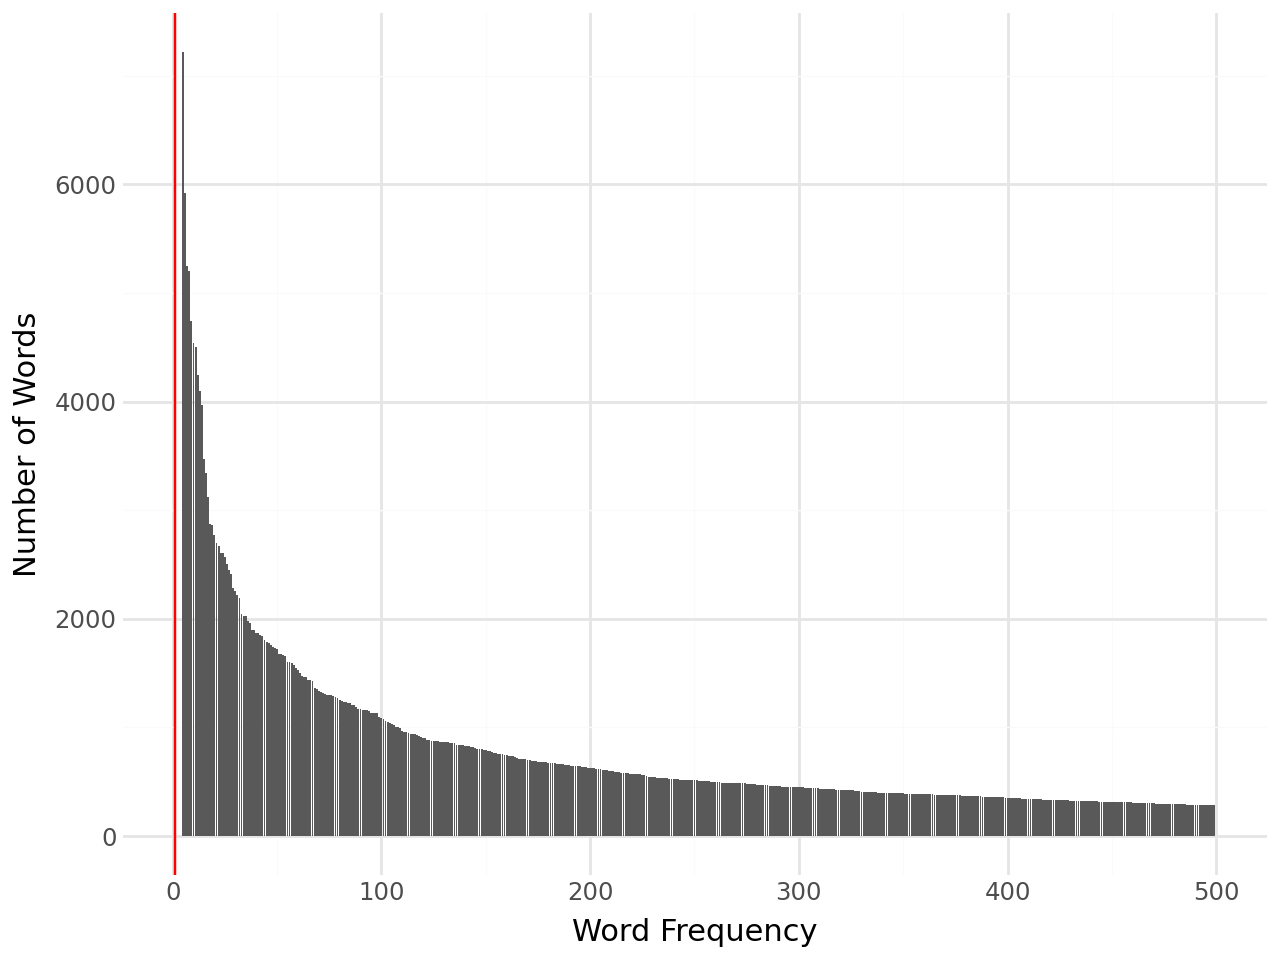

In [25]:
g = (ggplot(title_top[5:500,:], aes(x='index',y='cnt')) + geom_bar(stat='identity') + theme_minimal() +
    xlab('Word Frequency') + ylab('Number of Words') +
    geom_vline(xintercept = title_top['cnt'].median(), color='red'))
print(f'Median Title Word Frequency: {title_top['cnt'].median()}')
g

In [26]:
title_top.head(10)

index,vocab,cnt
u32,str,i64
0,""" """,190410
1,"""""""",19866
2,"""'""",14812
3,"""-""",12857
4,""":""",11910
5,"""ใน""",7220
6,"""ไทย""",5925
7,"""ที่""",5251
8,"""ไม่""",5205


In [27]:
title_top[100:].head(10)

index,vocab,cnt
u32,str,i64
100,"""ชุมชน""",1085
101,"""ต้าน""",1075
102,"""ไท""",1063
103,"""เรื่อง""",1053
104,"""ภาค""",1039
105,"""ล้าน""",1036
106,"""นี้""",1026
107,"""แต่""",1007
108,"""เข้า""",1001


In [28]:
title_top.tail(10)

index,vocab,cnt
u32,str,i64
44776,"""”，“合理使用”""",1
44777,"""…!!!""",1
44778,"""…”""",1
44779,"""‬:""",1
44780,"""′ค""",1
44781,"""′ณัฐ""",1
44782,"""′อั้ม""",1
44783,"""″""",1
44784,"""☘""",1


### Text Feature Correlations

In [29]:
label_df['label']

label
str
"""ข่าว"""
"""การเมือง"""
"""สิทธิมนุษยชน"""
"""คุณภาพชีวิต"""
"""บทความ"""
…
"""การซื้อโฆษณา"""
"""การทบทวนสถานการณ์สิทธิมนุษยชนไ…"
"""จรรยาบรรณสื่อมวลชน"""


In [30]:
from class_features import *
from sklearn.feature_extraction.text import TfidfVectorizer

title_vec = TfidfVectorizer(analyzer=process_text)
title_tfidf_mat = title_vec.fit_transform(prachathai['title'].to_numpy())
title_features = title_vec.get_feature_names_out()

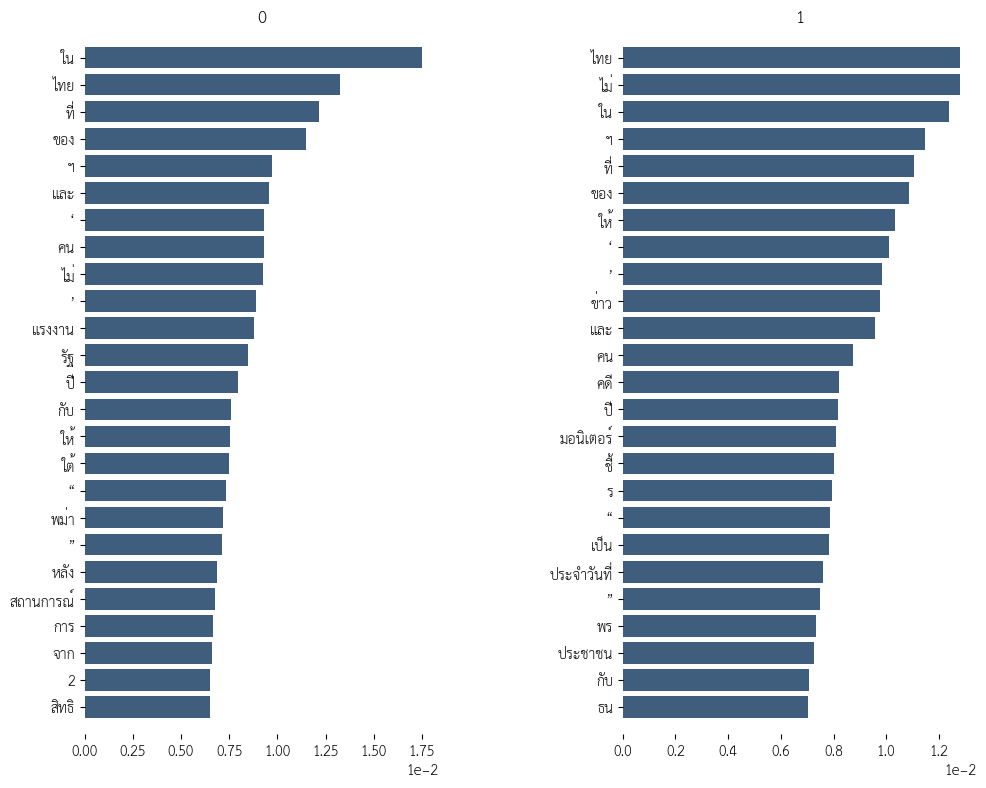

In [31]:
show_classfeats(
    df=prachathai_encoded,
    mat=title_tfidf_mat,
    features=title_features,
    class_col='การเมือง'
)

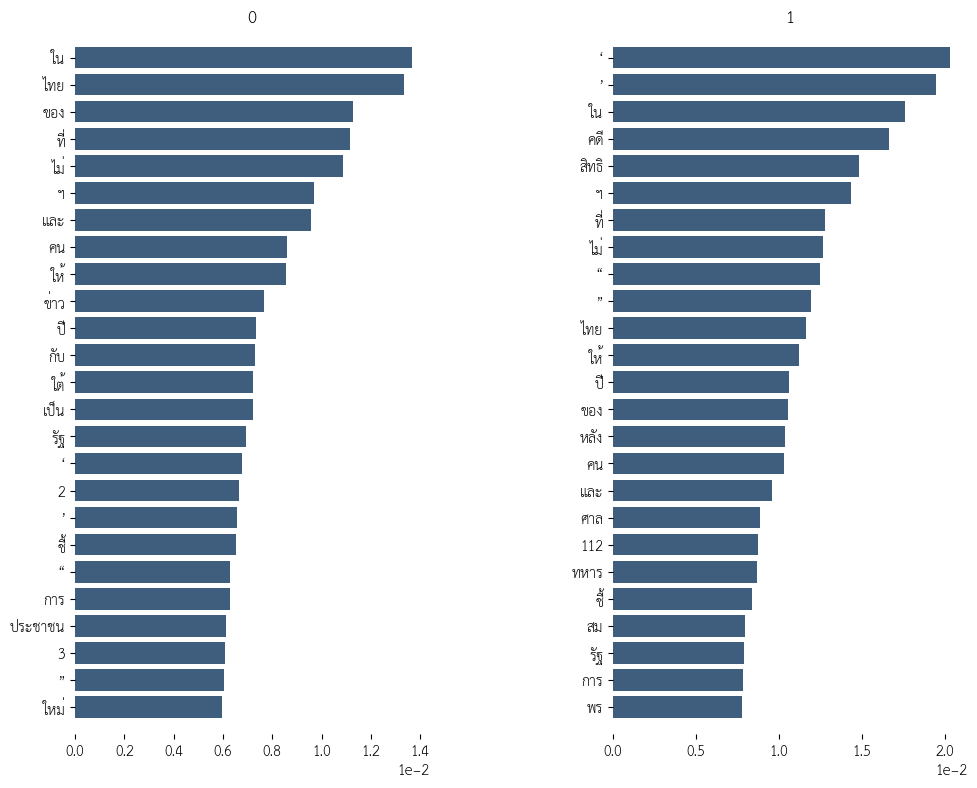

In [32]:
show_classfeats(
    df=prachathai_encoded,
    mat=title_tfidf_mat,
    features=title_features,
    class_col='สิทธิมนุษยชน'
)

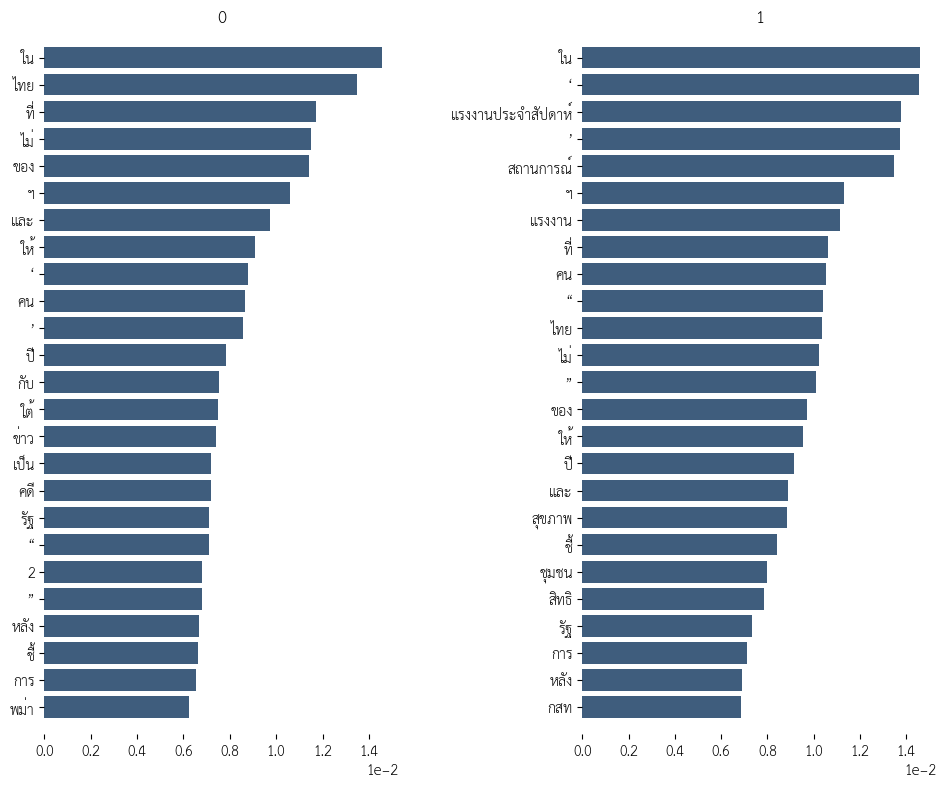

In [33]:
show_classfeats(
    df=prachathai_encoded,
    mat=title_tfidf_mat,
    features=title_features,
    class_col='คุณภาพชีวิต'
)

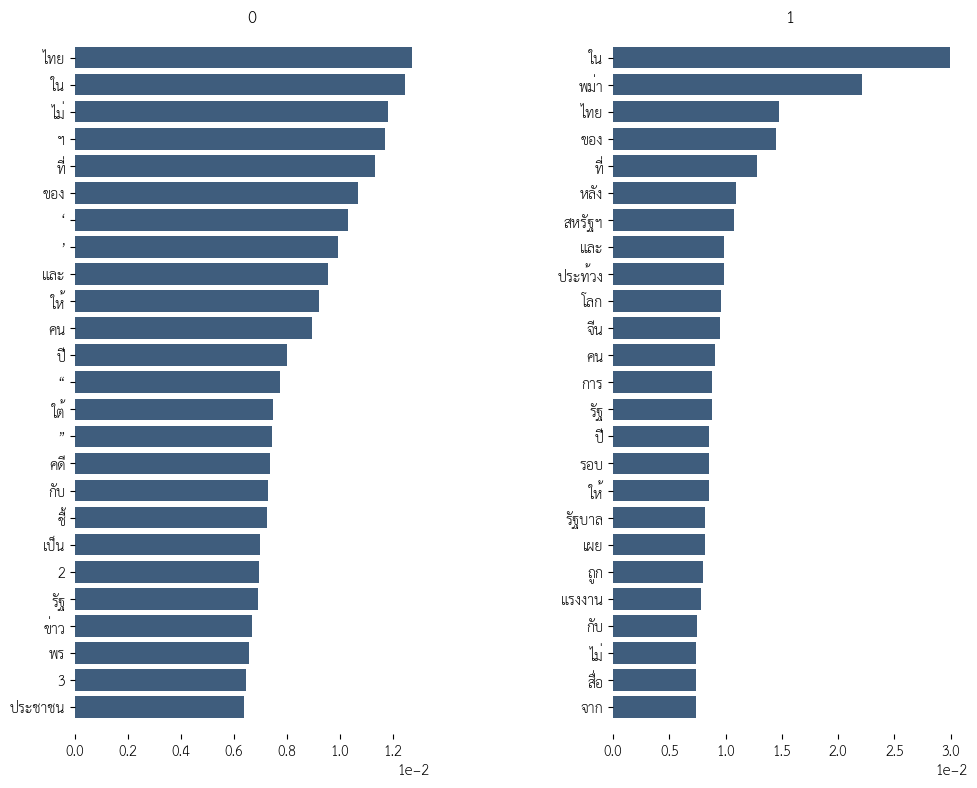

In [34]:
show_classfeats(
    df=prachathai_encoded,
    mat=title_tfidf_mat,
    features=title_features,
    class_col='ต่างประเทศ'
)

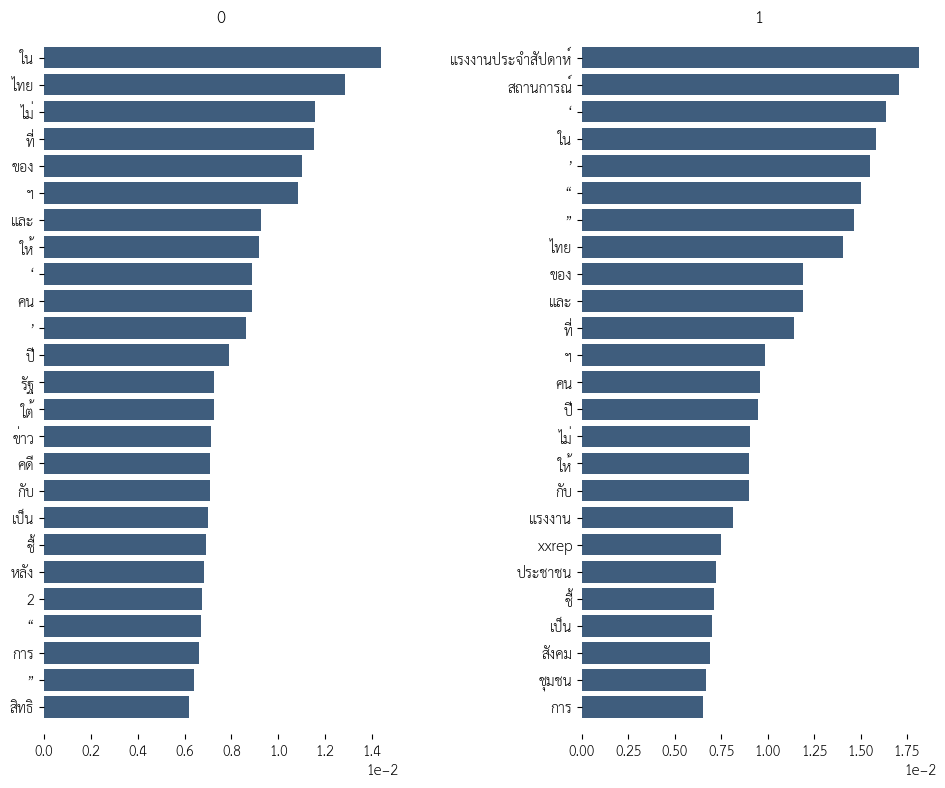

In [35]:
show_classfeats(
    df=prachathai_encoded,
    mat=title_tfidf_mat,
    features=title_features,
    class_col='สังคม'
)

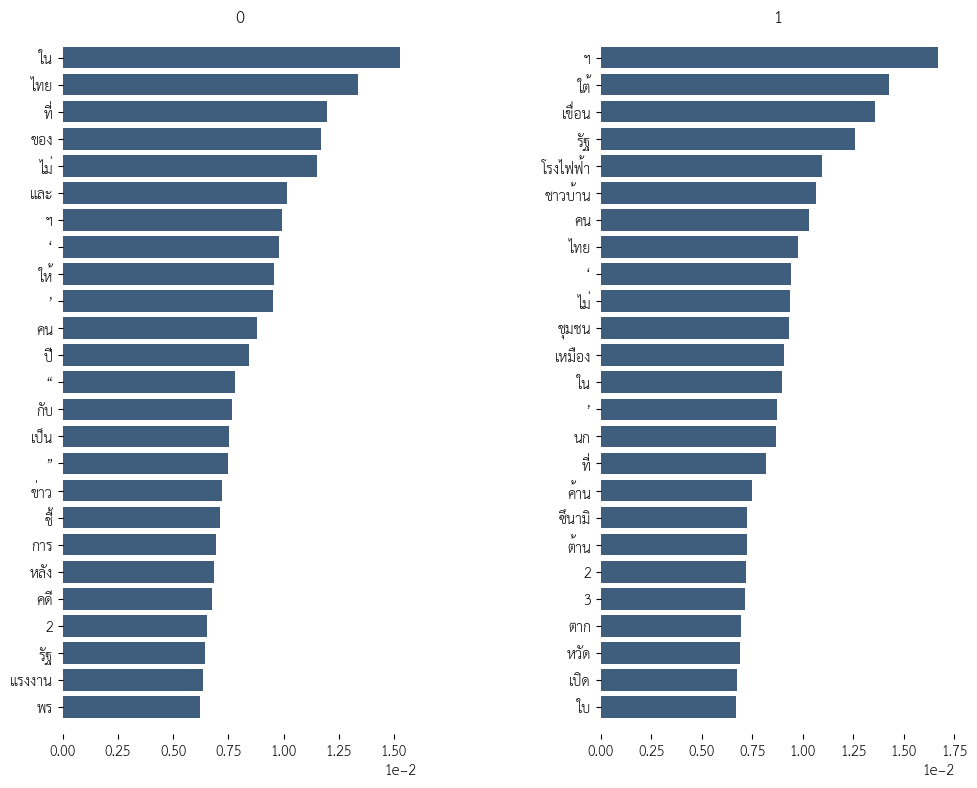

In [36]:
show_classfeats(
    df=prachathai_encoded,
    mat=title_tfidf_mat,
    features=title_features,
    class_col='สิ่งแวดล้อม'
)

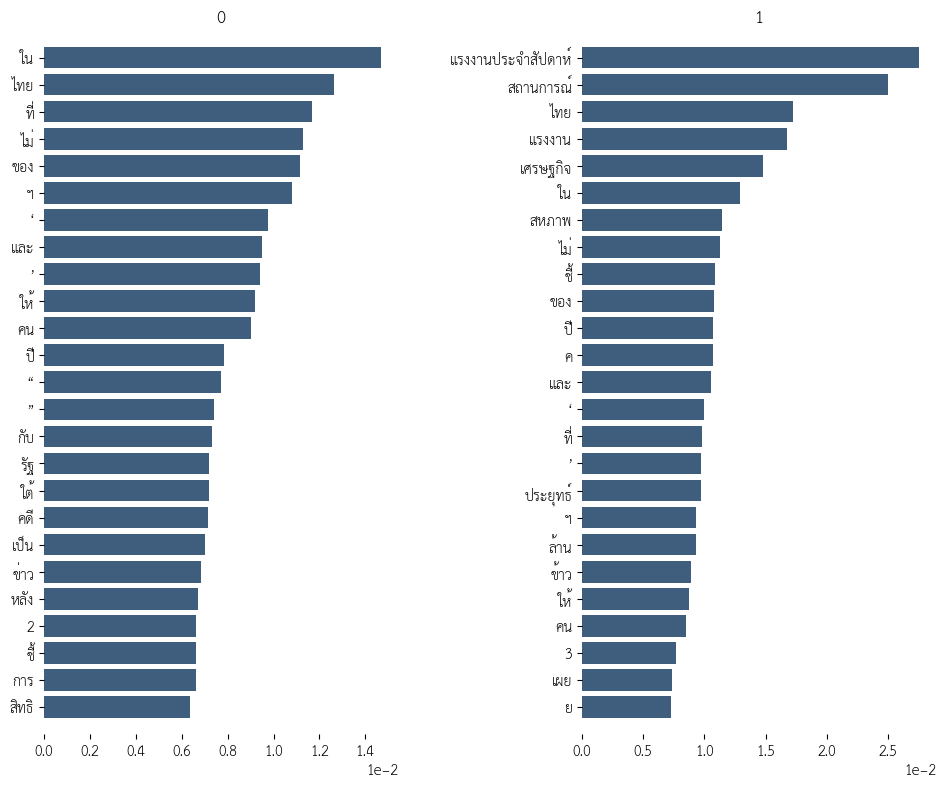

In [37]:
show_classfeats(
    df=prachathai_encoded,
    mat=title_tfidf_mat,
    features=title_features,
    class_col='เศรษฐกิจ'
)

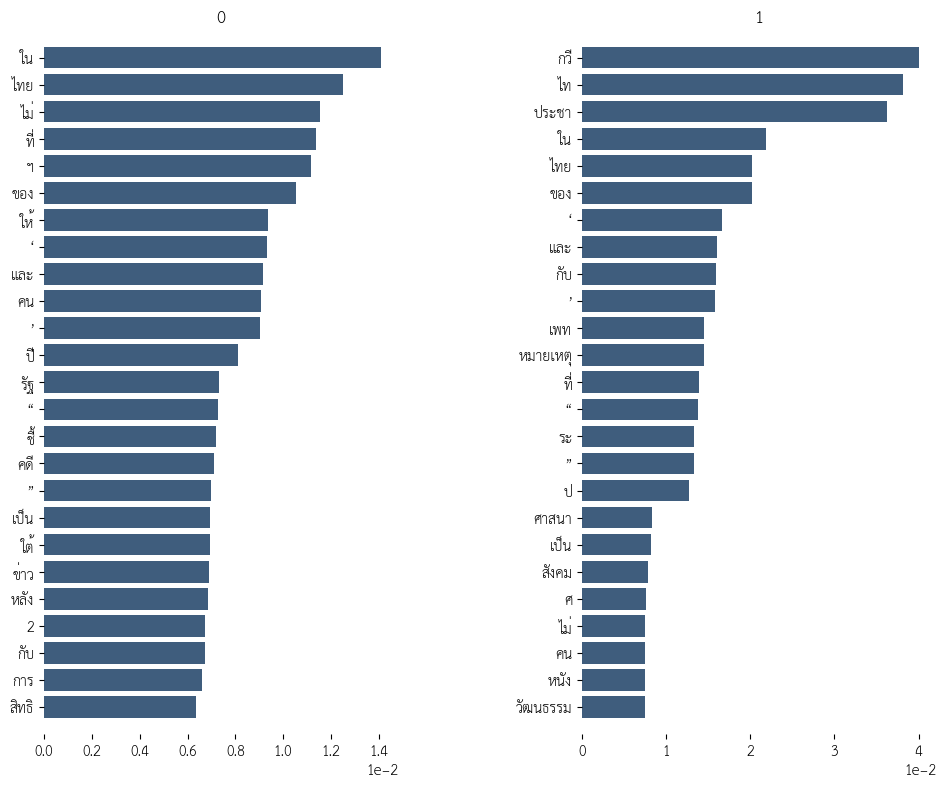

In [38]:
show_classfeats(
    df=prachathai_encoded,
    mat=title_tfidf_mat,
    features=title_features,
    class_col='วัฒนธรรม'
)

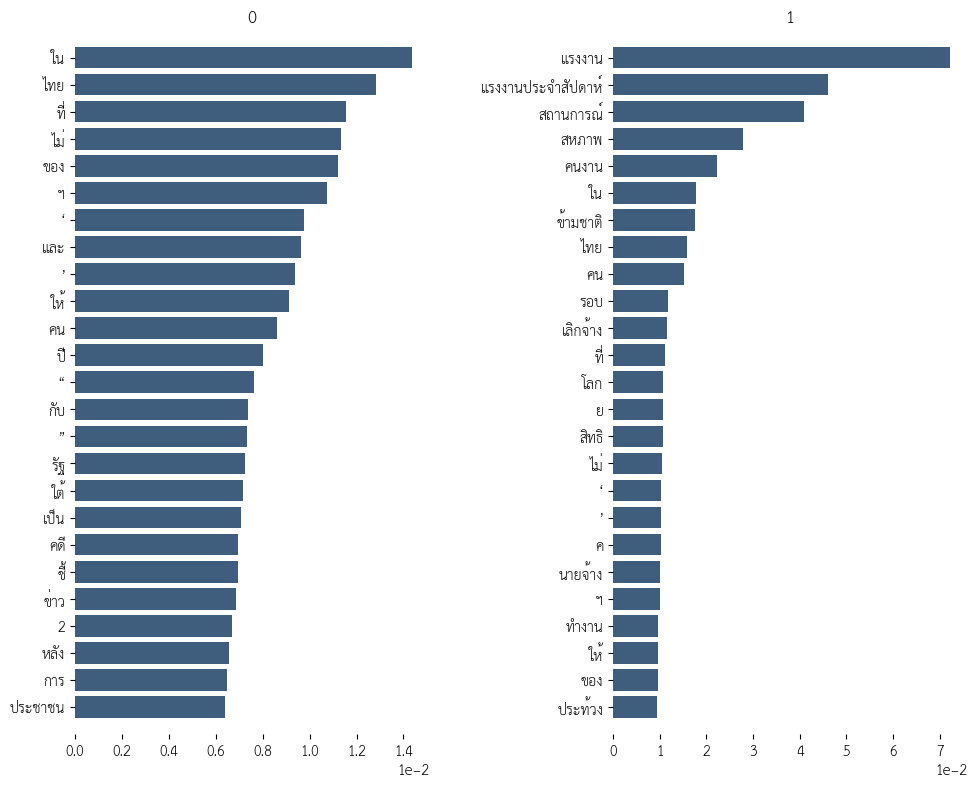

In [39]:
show_classfeats(
    df=prachathai_encoded,
    mat=title_tfidf_mat,
    features=title_features,
    class_col='แรงงาน'
)

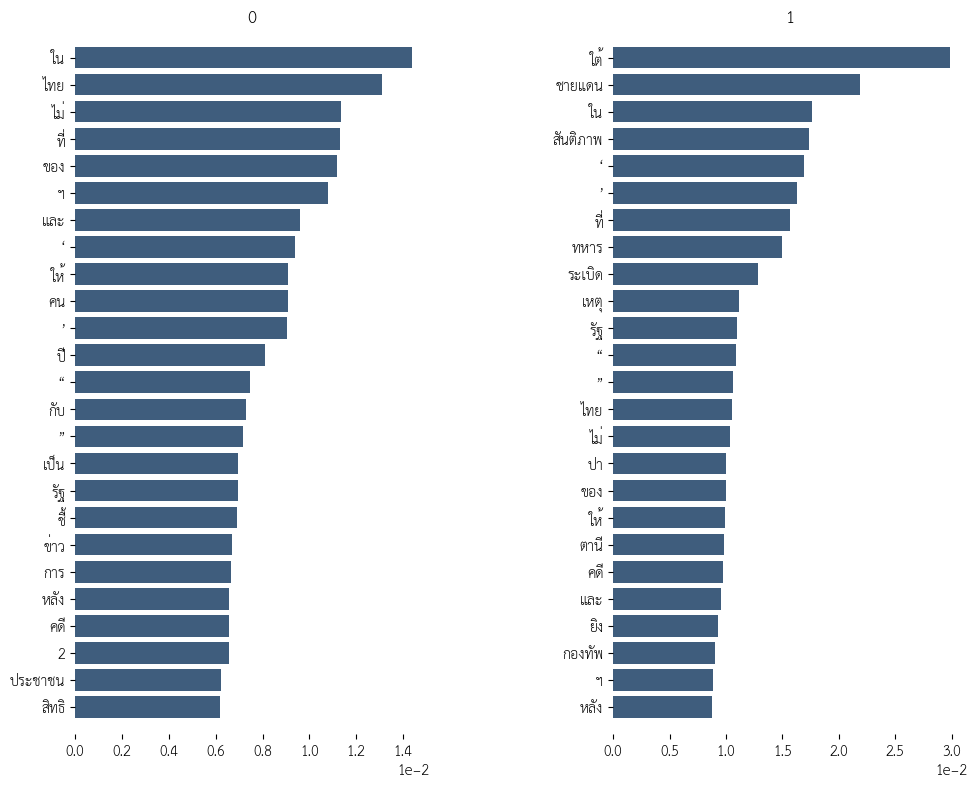

In [40]:
show_classfeats(
    df=prachathai_encoded,
    mat=title_tfidf_mat,
    features=title_features,
    class_col='ความมั่นคง'
)

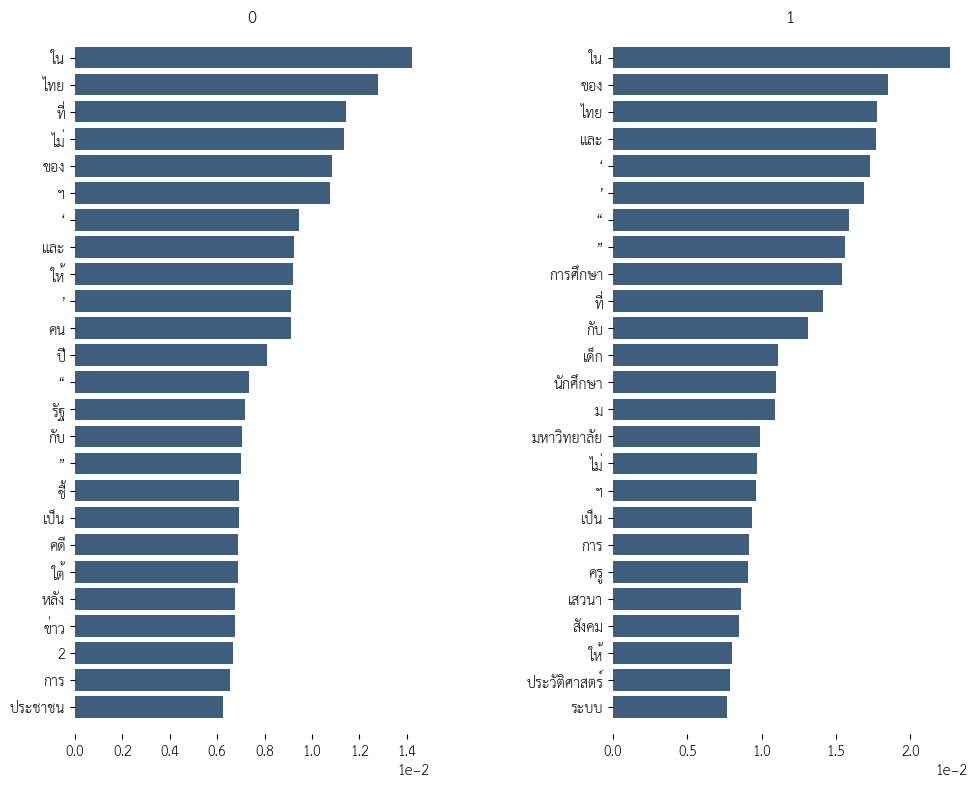

In [41]:
show_classfeats(
    df=prachathai_encoded,
    mat=title_tfidf_mat,
    features=title_features,
    class_col='การศึกษา'
)